# Fitting Neural Network Models
<a href="https://colab.research.google.com/github/cc-ats/mlp_class/blob/main/Lesson1_FNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this tutorial, we will learn how to use a neural network model to predict the energy of points on the Müller-Brown potential energy surface.

For the definition of Müller-Brown potential, see [here](https://www.wolframcloud.com/objects/demonstrations/TrajectoriesOnTheMullerBrownPotentialEnergySurface-source.nb.).

$v(x,y) = \sum_{k=0}^3 A_k \mathrm{exp}\left[ a_k (x - x_k^0)^2 + b_k (x - x_k^0) (y - y_k^0) + c_k (y - y_k^0)^2 \right] $

In [ ]:
from math import exp, pow, tanh
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

## Defining the Müller-Brown Potential Energy Function

In [ ]:
def mueller_brown_potential(x, y):
  A = [-200, -100, -170, 15]
  a = [-1, -1, -6.5, 0.7]
  b = [0, 0, 11, 0.6]
  c = [-10, -10, -6.5, 0.7]
  x0 = [1, 0, -0.5, -1.0]
  y0 = [0, 0.5, 1.5, 1]
  value = 0
  for k in range(4):
    value += 0.1 * A[k] * exp( a[k] * pow(x-x0[k], 2.0) + b[k] * (x-x0[k]) * (y-y0[k]) + c[k] * pow(y-y0[k], 2.0))
    #Scale the function by 0.1 to make plotting easier. 
  return value

### Generate Training Data

In order to use our neural network, we will first need to generate data to train the neural network.

In [ ]:
xx = np.arange(-1.8, 1.4, 0.1)
yy = np.arange(-0.4, 2.4, 0.1)
X, Y = np.meshgrid(xx, yy)
xy, xy_truncated = [],[]
z, z_truncated = [], []
for y in yy:
  for x in xx:
    v = mueller_brown_potential(x,y) #now using x and y values from the xx and yy arrays. CW 
    z.append(v) #storing potential energy values in the z array.
    xy.append([x,y])
    if v < 10:  #keep only low-energy points for training.
      xy_truncated.append([x, y])
      z_truncated.append(v)
Z = np.reshape(z,(len(yy),-1)) #reshape z array so that we can plot our data on a 2-D surface that is len(xx) by len(yy). CW
print("Zmin:", np.amin(Z), "Zmax:", np.amax(Z))
print("Size of (future) training set:", len(z_truncated))
print(len(z_truncated))

Zmin: -14.599803525171698 Zmax: 1194.4772333054245
Size of (future) training set: 696
696


### Visualizing Training Data: 3-D Projection Surface

We will now create a 3-D surface plot of our training data. To make the plot more readable, we will copy over the points that are extremely high energy with nan (not a number). This will keep our Z array the same shape and help us ignore the high energy region that we are not interested in.

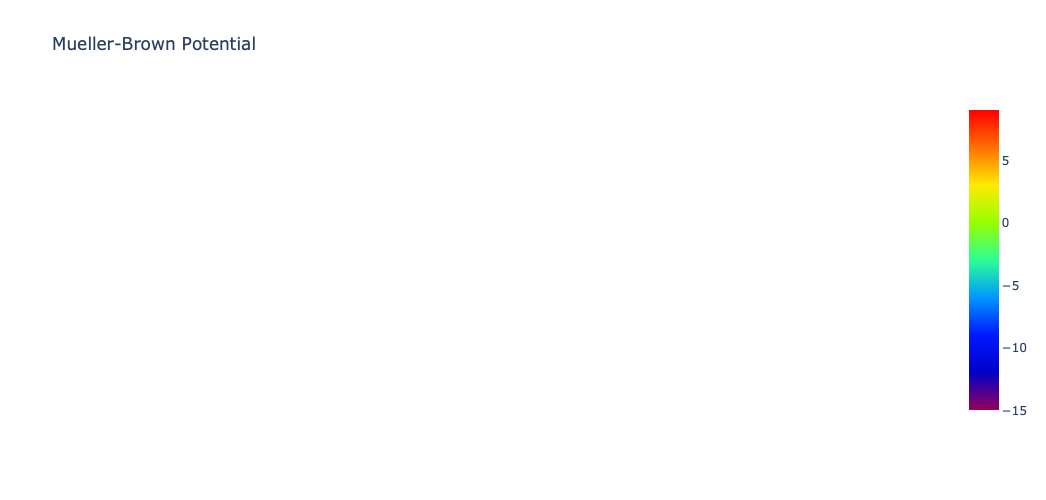

In [ ]:
fig = go.Figure(data=[go.Surface(z=Z, x=X, y=Y, colorscale='rainbow', cmin=-15, cmax=9)])
fig.update_traces(contours_z=dict(show=True, project_z=True))
fig.update_layout(title='Mueller-Brown Potential', width=500, height=500,
                  scene = dict(
                      zaxis = dict(dtick=3, range=[-15, 15]),
                      camera_eye = dict(x=-1.2, y=-1.2, z=1.2)))
fig.show()

### Visualizing Training Data: Contour Surface

Now we will create a contour surface plot of our training data

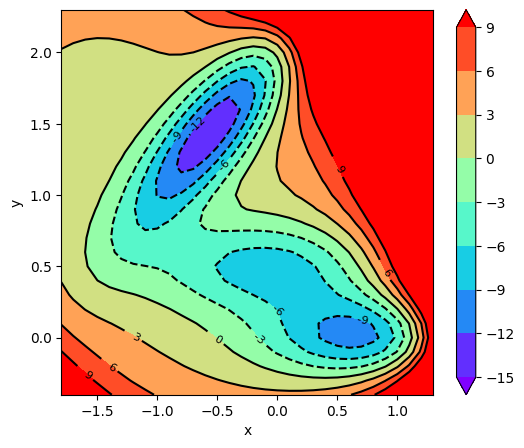

In [ ]:
fig = plt.figure(figsize=(6, 5), dpi=100)
levels = [-15, -12, -9, -6, -3, 0, 3, 6, 9]
ct = plt.contour(X, Y, Z, levels, colors="k")
plt.clabel(ct, inline=True, fmt="%3.0f", fontsize=8)
ct = plt.contourf(X, Y, Z, levels, cmap=plt.cm.rainbow, extend="both", vmin=-15, vmax=10)
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar()
plt.show()

## Loading PyTorch and training data

After installing and importing pytorch, we will save our training data as a tensor data set.

In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import TensorDataset, DataLoader, random_split

dataset = TensorDataset(Tensor(xy_truncated), Tensor(z_truncated))
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
print("Size of training set:", len(train_loader.dataset))

Size of training set: 696


### A Basic Neural Network

Below is a schematic of a neural netowrk. Inputs (x, y) are given weights (w) and biases (b) and are used as a value (v) for the activation function (tanh) at the input layer. The activation function decides the activity or contribution of each neuron in the input layer. Weights (w') and biases (b') are applied to the value (v') returned by the activation function and used to create the predicted value in the output layer ($V^{pred}$). 

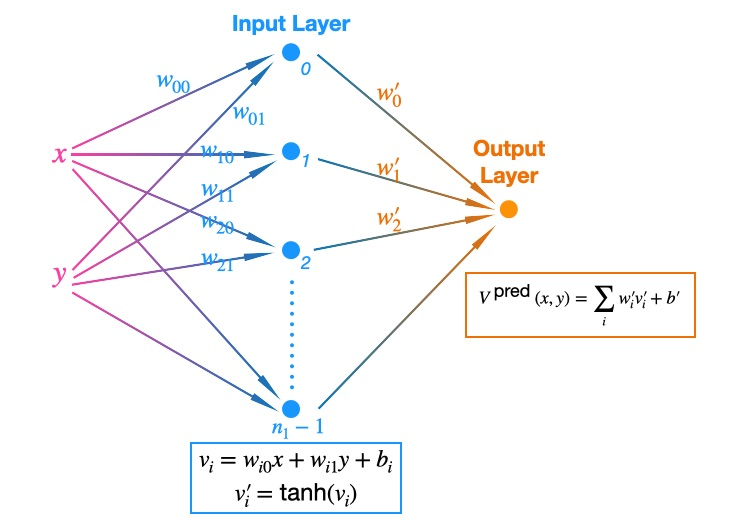

## Defining the Neural Network Class

Here we define our neural network as a python class. We also define a function to loop through our training data.

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, n1=20):  # n1 is the number of neurons for the first layer
        super().__init__()
        self.model = nn.Sequential(nn.Linear(2, n1), nn.Tanh(), nn.Linear(n1, 1))

    def forward(self, x):
        return self.model(x)


def train_loop(dataloader, model, optimizer, i_epoch):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = F.mse_loss(pred.squeeze(), y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 15 == 0 and i_epoch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(
                f"epoch: {i_epoch:>3d} loss: {loss:>7.3f}  [{current:>5d}/{size:>5d}]"
            )

## Training the Model

Now we can train the machine learning model. We will finish our training when the desired number of epochs has been reached. We will also define some terms used for training below. 
Epochs - Number of forward/backward passes through the entire neural network. 
Learning Rate - Determines the step size as we try to optimize the loss function. A faster learning rate would have a larger step size. 
Stochastic Gradient Descent (SGD) - The algorithm used for optimizing the loss function.

In [ ]:
# Training of Machine Learning Model

learning_rate = 1e-2
epochs = 1000
n1 = 20
model = NeuralNetwork(n1)
loss_fn = F.mse_loss
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for t in range(epochs):
    train_loop(train_loader, model, optimizer, t)
    # prints: "epoch:", every 100 epochs, "loss:", error from the loss function, [   current position in traning set/ size of training set]
    # Note: In this example, there are 696 training points broken into 21 batches of batch size 32 (672 training points). 
    # That means there is an extra batch of 24 training points. When added together, this gives the full 696 training points. 
print("Done with Training!")

epoch:   0 loss:  30.888  [    0/  696]
epoch:   0 loss:  20.242  [  480/  696]
epoch: 100 loss:   2.754  [    0/  696]
epoch: 100 loss:   4.147  [  480/  696]
epoch: 200 loss:   1.587  [    0/  696]
epoch: 200 loss:   0.913  [  480/  696]
epoch: 300 loss:   1.562  [    0/  696]
epoch: 300 loss:   1.960  [  480/  696]
epoch: 400 loss:   0.600  [    0/  696]
epoch: 400 loss:   1.452  [  480/  696]
epoch: 500 loss:   0.700  [    0/  696]
epoch: 500 loss:   0.759  [  480/  696]
epoch: 600 loss:   0.394  [    0/  696]
epoch: 600 loss:   0.685  [  480/  696]
epoch: 700 loss:   0.589  [    0/  696]
epoch: 700 loss:   0.598  [  480/  696]
epoch: 800 loss:   0.626  [    0/  696]
epoch: 800 loss:   0.546  [  480/  696]
epoch: 900 loss:   0.733  [    0/  696]
epoch: 900 loss:   0.655  [  480/  696]
Done with Training!


## Plotting Reference, Predicted, and Difference Surfaces

Finally, we will plot the Müller-Brown potential energy surface using the analytical function (reference), using the neural network (predicted), and we will show the difference between the predicted and reference surfaces.

diff, min, max: -1173.5299524216355 3.2799263790029496


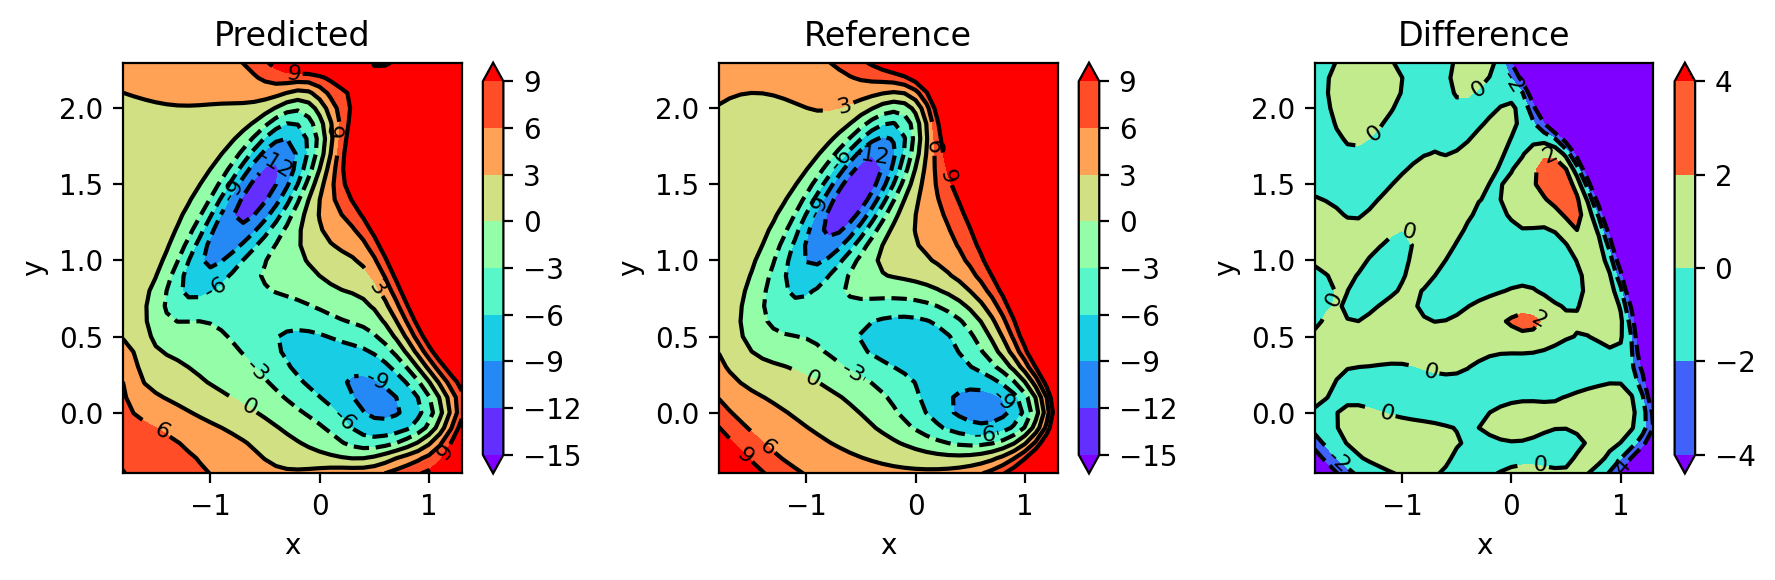

In [ ]:
# Show the predicted surface, and compare to the reference one
def show_surface(model):
    z_pred = model(Tensor(xy))
    Z_pred = np.reshape(z_pred.detach().numpy(), (len(yy), -1))
    Zdiff = np.subtract(Z_pred, Z)

    fig = plt.figure(figsize=(9, 3), dpi=200)

    plt.subplot(1, 3, 1)
    levels = [-15, -12, -9, -6, -3, 0, 3, 6, 9]
    ct = plt.contour(X, Y, Z_pred, levels, colors="k")
    plt.clabel(ct, inline=True, fmt="%3.0f", fontsize=8)
    ct = plt.contourf(X, Y, Z_pred, levels, cmap=plt.cm.rainbow, extend="both", vmin=-15, vmax=10)
    plt.title("Predicted")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.colorbar()

    plt.subplot(1, 3, 2)
    levels = [-15, -12, -9, -6, -3, 0, 3, 6, 9]
    ct = plt.contour(X, Y, Z, levels, colors="k")
    plt.clabel(ct, inline=True, fmt="%3.0f", fontsize=8)
    ct = plt.contourf(X, Y, Z, levels, cmap=plt.cm.rainbow, extend="both", vmin=-15, vmax=10)
    plt.title("Reference")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.colorbar()

    plt.subplot(1, 3, 3)
    levels = [-4, -2, 0, 2, 4]
    ct = plt.contour(X, Y, Zdiff, levels, colors="k")
    plt.clabel(ct, inline=True, fmt="%3.0f", fontsize=8)
    ct = plt.contourf(X, Y, Zdiff, levels, cmap=plt.cm.rainbow, extend="both", vmin=-4, vmax=4)
    plt.title("Difference")
    plt.xlabel("x")
    plt.ylabel("y")
    print("diff, min, max:", np.amin(Zdiff), np.amax(Zdiff))
    plt.colorbar()

    plt.tight_layout()

    plt.show()


show_surface(model)

## Taking a Look at the NN parameters

In order to take a closer look at the neural network parameters, we can define the two linear functions and activation function for the neural network explicitly.

In [ ]:
print("model:", model)

for name, param in model.named_parameters():
    # print(name, param.data)
    if name == "model.0.weight":
        weights0 = param.data.detach().numpy()
    elif name == "model.0.bias":
        bias0 = param.data.detach().numpy()
    elif name == "model.2.weight":
        weights2 = param.data.detach().numpy()
    elif name == "model.2.bias":
        bias2 = param.data.detach().numpy()

xy0 = np.array([-0.5, 1.5])
z0 = model(Tensor(xy0))

# print("weights2:", weights2)
# print("bias2:", bias2)

# first linear function
v1 = np.zeros(n1)
for i in range(0, n1):
    v1[i] += weights0[i, 0] * xy0[0] + weights0[i, 1] * xy0[1] + bias0[i]

# activation function
v2 = np.zeros(n1)
for i in range(0, n1):
    v2[i] = tanh(v1[i])

# second linear function
z_pred = 0.0
for i in range(0, n1):
    z_pred += weights2[0, i] * v2[i]
z_pred += bias2[0]

print("z0:", z0, "z_pred:", z_pred)

# print(model[0].weight)

model: NeuralNetwork(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=1, bias=True)
  )
)
z0: tensor([-13.2039], grad_fn=<AddBackward0>) z_pred: -13.203932396559562


In [ ]:
print("model:", model)

# Ordered dictionary with all parameters (Linear 1, Activation, and Linear 2)
params = model.state_dict()

xy0 = np.array([-0.5, 1.5])
z0 = model(Tensor(xy0))

# First Linear Function
v1 = np.zeros(n1)
for i in range(n1):
    v1[i] = (
        params["model.0.weight"][i][0] * xy0[0]
        + params["model.0.weight"][i][1] * xy0[1]
        + params["model.0.bias"][i]
    )

# Activation Function
v2 = np.zeros(n1)
for i in range(n1):
    v2[i] = tanh(v1[i])

# Second Linear Function
z_pred = 0.0
for i in range(n1):
    z_pred += params["model.2.weight"][0, i] * v2[i]
z_pred += params["model.2.bias"][0]

print("z0:", z0, "\nz_pred:", z_pred)

model: NeuralNetwork(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=1, bias=True)
  )
)
z0: tensor([-13.2039], grad_fn=<AddBackward0>) 
z_pred: tensor(-13.2039)
